<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# collect texts

In [12]:
import html
import os
import re
import shutil
from bs4 import BeautifulSoup

In [ ]:
!pip install razdel

In [10]:
from razdel import sentenize
from tqdm import tqdm

In [ ]:
!git clone https://github.com/tolstoydigital/TEI.git

In [3]:
relevant_dirs = ['diaries', 'letters', 'notes', 'works']

In [4]:
path = 'TEI/reference/bibllist_works.xml'
xml = open(path).read()
soup = BeautifulSoup(xml, features="xml")

In [5]:
group_texts = {}
for it in soup.find_all("item"):
  ref = it.find("ref")
  for related in it.find_all("relatedItem"):
    for ref_ana in related.find_all("ref"):
      group_texts[ref_ana.text] = ref.text

In [6]:
prefix_texts = 'extracted_texts'
os.mkdir(prefix_texts)

In [13]:
if os.path.exists(prefix_texts):
  shutil.rmtree(prefix_texts)
os.mkdir(prefix_texts)

complex_texts = {}
for rel_dir in relevant_dirs:
  path = os.path.join('TEI/texts', rel_dir)
  for file in tqdm(sorted(os.listdir(path))):
    fiction = 0
    if not file.endswith('.xml'):
      continue
    xml = open(os.path.join(path, file)).read()
    if 'Печатные варианты' in xml:
      continue
    nameID = file.replace('.xml', '')
    soup = BeautifulSoup(xml, features="xml")
    if soup.find("catRef", {"ana":"#fiction"}):
      fiction = 1
    s = soup.find("body")
    paragraphs = []
    for erase in s.find_all(["orig", "comments", "sic", "note"]):
      erase.decompose()
    for p in s.find_all(["p", "l"]):
      paragraphs.append(html.unescape(p.text.replace('\n', ' ').strip()))
    if not fiction:
      with open(os.path.join(prefix_texts, rel_dir + '.txt'), 'a') as f:
        for par in paragraphs:
          par = re.sub(' ([.,;:!?)"»])', '\\1', par)
          par = par.replace('\n', ' ')
          par = par.strip()
          par = re.sub('\s+', ' ', par)
          par = re.sub('\[.+?\]', '', par)
          for sent in sentenize(par):
            f.write(list(sent)[2].strip() + '\n')
    else:
      if nameID in group_texts:
        hyper_name = group_texts[nameID]
        if hyper_name not in complex_texts:
          complex_texts[hyper_name] = paragraphs
        else:
          complex_texts[hyper_name].extend(paragraphs)
      else:
        with open(os.path.join(prefix_texts, nameID + '.txt'), 'w') as f:
          f.write('\n'.join(paragraphs))
for hyper_name in complex_texts:
  with open(os.path.join(prefix_texts, hyper_name + '.txt'), 'w') as f:
    f.write('\n'.join(complex_texts[hyper_name]))

100%|██████████| 767/767 [02:49<00:00,  4.53it/s]


# tagging

In [14]:
from pymystem3 import Mystem

In [19]:
def tagging():
    m = Mystem()
    for fl in os.listdir(prefix_texts):
        #print(fl)
        if 'mystem' in fl:
            continue
        with open(os.path.join(prefix_texts, fl)) as f:
            text = f.read()
        lines = text.split('\n')
        ana_lines = []
        for line in lines:
            line = ' '.join(line.split()[1:])
            line = line.replace('ò', 'о')
            line = line.replace('è', 'е')
            line = line.replace('à', 'а')
            line = line.replace('ѝ', 'и')
            line = line.replace('ỳ', 'у')
            line = line.replace('о̀', 'о')
            #line = line.replace('Изд.̀', 'издательство')
            ana = []
            info = m.analyze(line)
            for token in info:
                if "analysis" in token:
                    try:
                        analysis = token["analysis"][0]
                    except:
                        #print(token)
                        continue
                    # if "lex" in analysis:
                    lex = analysis["lex"]
                    #if 'gr' in analysis:
                    gr = analysis['gr']
                    #print(gr)
                    const = gr.split('=')[0]
                    if ',' in const:
                        pos = const.split(',')[0]
                    else:
                        pos = const
                    
                    ana.append('{}_{}'.format(lex, pos))
            ln = ' '.join(ana)
            if re.search('[А-Яа-я]', ln):
                ana_lines.append(ln)
        with open('{}/mystem-{}'.format(prefix_texts, fl), 'w') as fw:
            fw.write('\n'.join(ana_lines))

In [20]:
tagging()

In [18]:
pos = ['S', 'V', 'A', 'ADV']

In [22]:
def mk_input():
    inp = []
    for fl in os.listdir(prefix_texts):
        if not 'mystem' in fl:
            continue
        #print(fl)
        with open(os.path.join(prefix_texts, fl)) as f:
            text = f.read()
        lines = text.split('\n')
        for line in lines:
            words = []
            for w in line.split():
                word = w.split('_')
                if word[1] in pos:
                    words.append(w)
            if len(words) > 1:
                inp.append(' '.join(words))
    
    with open('input.txt', 'w') as fw:
        fw.write('\n'.join(inp))
        
mk_input()

# build models

In [26]:
import sys
import logging
import gensim

In [24]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [27]:
pth = './input.txt'
data = gensim.models.word2vec.LineSentence(pth)

In [28]:
modelLNT1 = gensim.models.Word2Vec(data, vector_size=500, window=2, min_count=2, sg=1) # comparable with web_mystem_skipgram_500_2_2015.bin
modelLNT1.save('skipgram_500_2.model') # modelLNT1 = Word2Vec.load("skipgram_500_2.model")

2024-06-16 03:15:24,273 : INFO : collecting all words and their counts
2024-06-16 03:15:24,278 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-16 03:15:24,440 : INFO : PROGRESS: at sentence #10000, processed 163169 words, keeping 17313 word types
2024-06-16 03:15:24,556 : INFO : PROGRESS: at sentence #20000, processed 296024 words, keeping 23165 word types
2024-06-16 03:15:24,672 : INFO : PROGRESS: at sentence #30000, processed 405629 words, keeping 26267 word types
2024-06-16 03:15:24,800 : INFO : PROGRESS: at sentence #40000, processed 494131 words, keeping 27548 word types
2024-06-16 03:15:24,929 : INFO : PROGRESS: at sentence #50000, processed 582330 words, keeping 28502 word types
2024-06-16 03:15:25,090 : INFO : PROGRESS: at sentence #60000, processed 706637 words, keeping 30127 word types
2024-06-16 03:15:25,233 : INFO : PROGRESS: at sentence #70000, processed 847070 words, keeping 35040 word types
2024-06-16 03:15:25,373 : INFO : PROGRESS: at 

2024-06-16 03:15:45,538 : INFO : EPOCH 1 - PROGRESS: at 4.82% examples, 245175 words/s, in_qsize 5, out_qsize 1
2024-06-16 03:15:46,538 : INFO : EPOCH 1 - PROGRESS: at 13.74% examples, 264455 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:15:47,560 : INFO : EPOCH 1 - PROGRESS: at 20.30% examples, 271388 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:15:48,571 : INFO : EPOCH 1 - PROGRESS: at 27.11% examples, 273492 words/s, in_qsize 6, out_qsize 0
2024-06-16 03:15:49,589 : INFO : EPOCH 1 - PROGRESS: at 37.36% examples, 266737 words/s, in_qsize 6, out_qsize 0
2024-06-16 03:15:50,610 : INFO : EPOCH 1 - PROGRESS: at 49.03% examples, 270570 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:15:51,651 : INFO : EPOCH 1 - PROGRESS: at 55.81% examples, 269964 words/s, in_qsize 3, out_qsize 2
2024-06-16 03:15:52,652 : INFO : EPOCH 1 - PROGRESS: at 59.80% examples, 270869 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:15:53,694 : INFO : EPOCH 1 - PROGRESS: at 63.30% examples, 270642 words/s, in_qsize

2024-06-16 03:16:45,056 : INFO : not storing attribute cum_table
2024-06-16 03:16:45,084 : INFO : saved skipgram_500_2.model


In [29]:
modelLNT2 = gensim.models.Word2Vec(data, vector_size=300, window=10, min_count=2, sg=0) # comparable with ruwikiruscorpora_upos_cbow_300_10_2021
modelLNT2.save('cbow_300_10.model')

2024-06-16 03:16:56,049 : INFO : collecting all words and their counts
2024-06-16 03:16:56,052 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-16 03:16:56,262 : INFO : PROGRESS: at sentence #10000, processed 163169 words, keeping 17313 word types
2024-06-16 03:16:56,392 : INFO : PROGRESS: at sentence #20000, processed 296024 words, keeping 23165 word types
2024-06-16 03:16:56,513 : INFO : PROGRESS: at sentence #30000, processed 405629 words, keeping 26267 word types
2024-06-16 03:16:56,602 : INFO : PROGRESS: at sentence #40000, processed 494131 words, keeping 27548 word types
2024-06-16 03:16:56,705 : INFO : PROGRESS: at sentence #50000, processed 582330 words, keeping 28502 word types
2024-06-16 03:16:56,833 : INFO : PROGRESS: at sentence #60000, processed 706637 words, keeping 30127 word types
2024-06-16 03:16:56,977 : INFO : PROGRESS: at sentence #70000, processed 847070 words, keeping 35040 word types
2024-06-16 03:16:57,114 : INFO : PROGRESS: at 

2024-06-16 03:17:16,847 : INFO : EPOCH 1 - PROGRESS: at 55.19% examples, 308798 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:17:17,859 : INFO : EPOCH 1 - PROGRESS: at 62.24% examples, 336579 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:17:18,881 : INFO : EPOCH 1 - PROGRESS: at 66.86% examples, 337849 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:17:19,889 : INFO : EPOCH 1 - PROGRESS: at 79.56% examples, 342120 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:17:20,947 : INFO : EPOCH 1 - PROGRESS: at 87.02% examples, 326518 words/s, in_qsize 6, out_qsize 0
2024-06-16 03:17:21,959 : INFO : EPOCH 1 - PROGRESS: at 100.00% examples, 330219 words/s, in_qsize 0, out_qsize 1
2024-06-16 03:17:21,961 : INFO : EPOCH 1: training on 4013071 raw words (3707615 effective words) took 11.2s, 330162 effective words/s
2024-06-16 03:17:22,981 : INFO : EPOCH 2 - PROGRESS: at 11.53% examples, 467727 words/s, in_qsize 5, out_qsize 0
2024-06-16 03:17:23,992 : INFO : EPOCH 2 - PROGRESS: at 22.81% examples, 

# most similar words viz

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [34]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa0f8423f70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


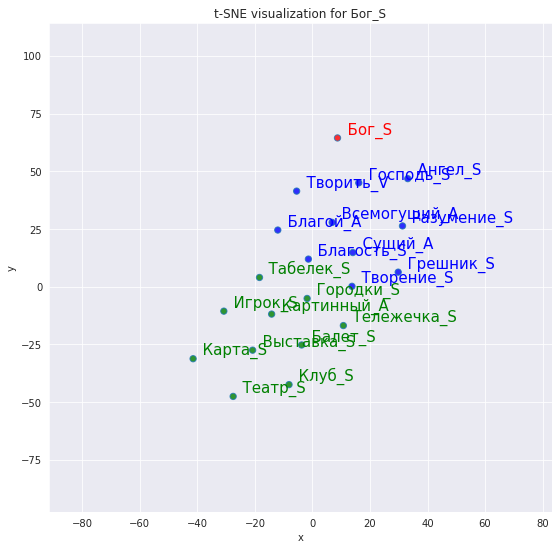

In [35]:
tsnescatterplot(modelLNT2, 'бог_S', [i[0] for i in modelLNT2.wv.most_similar(negative=["бог_S"])])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa0fc640dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


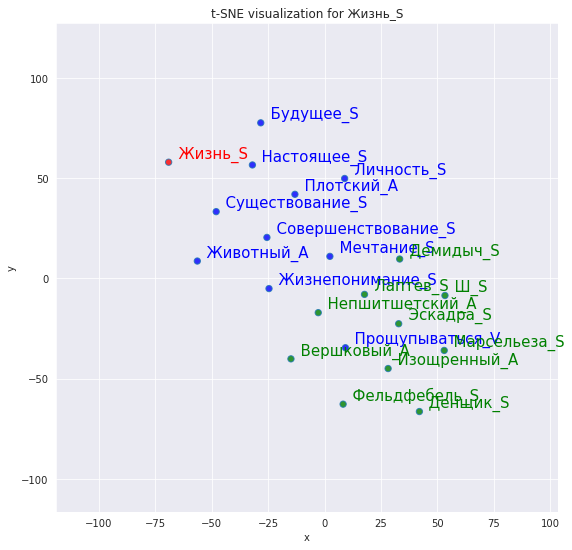

In [36]:
tsnescatterplot(modelLNT2, 'жизнь_S', [i[0] for i in modelLNT2.wv.most_similar(negative=["жизнь_S"])])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa0fa6c4280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


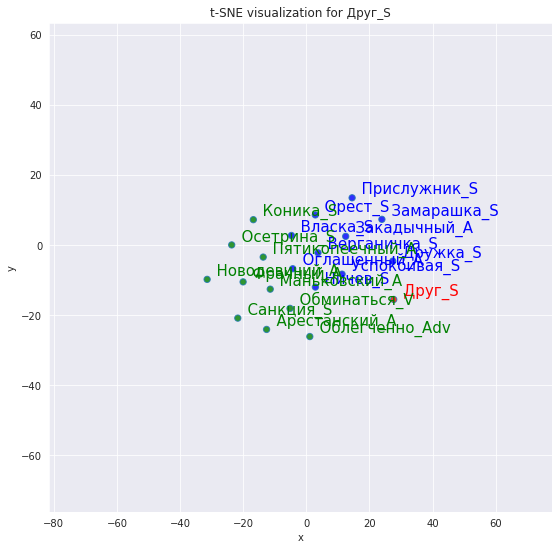

In [40]:
tsnescatterplot(modelLNT2, 'друг_S', [i[0] for i in modelLNT2.wv.most_similar(negative=["друг_S"])])